In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
os.getcwd()

'/Users/ramseyissa/Documents/GitHub/qNIPV/notebooks'

In [ ]:
# import npy files from results folder
# results_folder = 'results'
# data = np.load('data.npy')


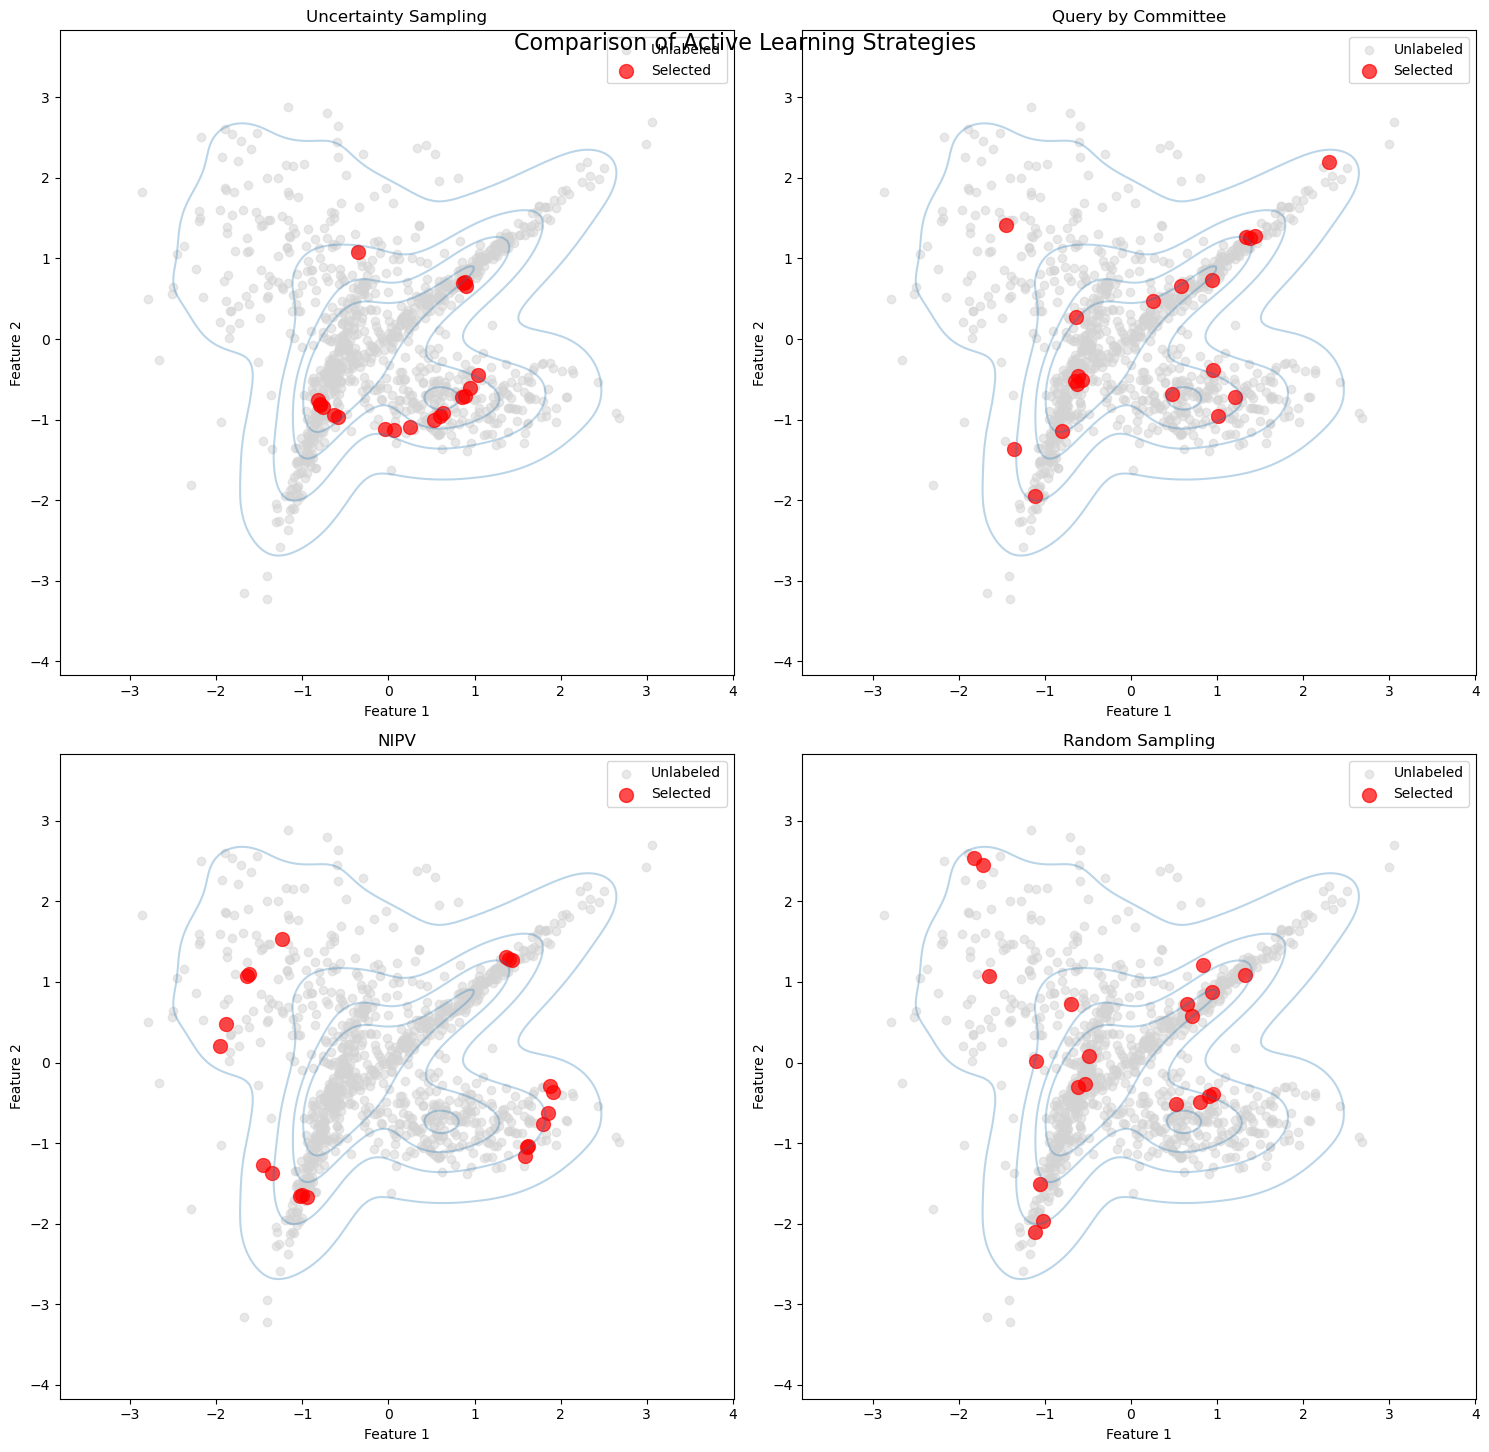

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


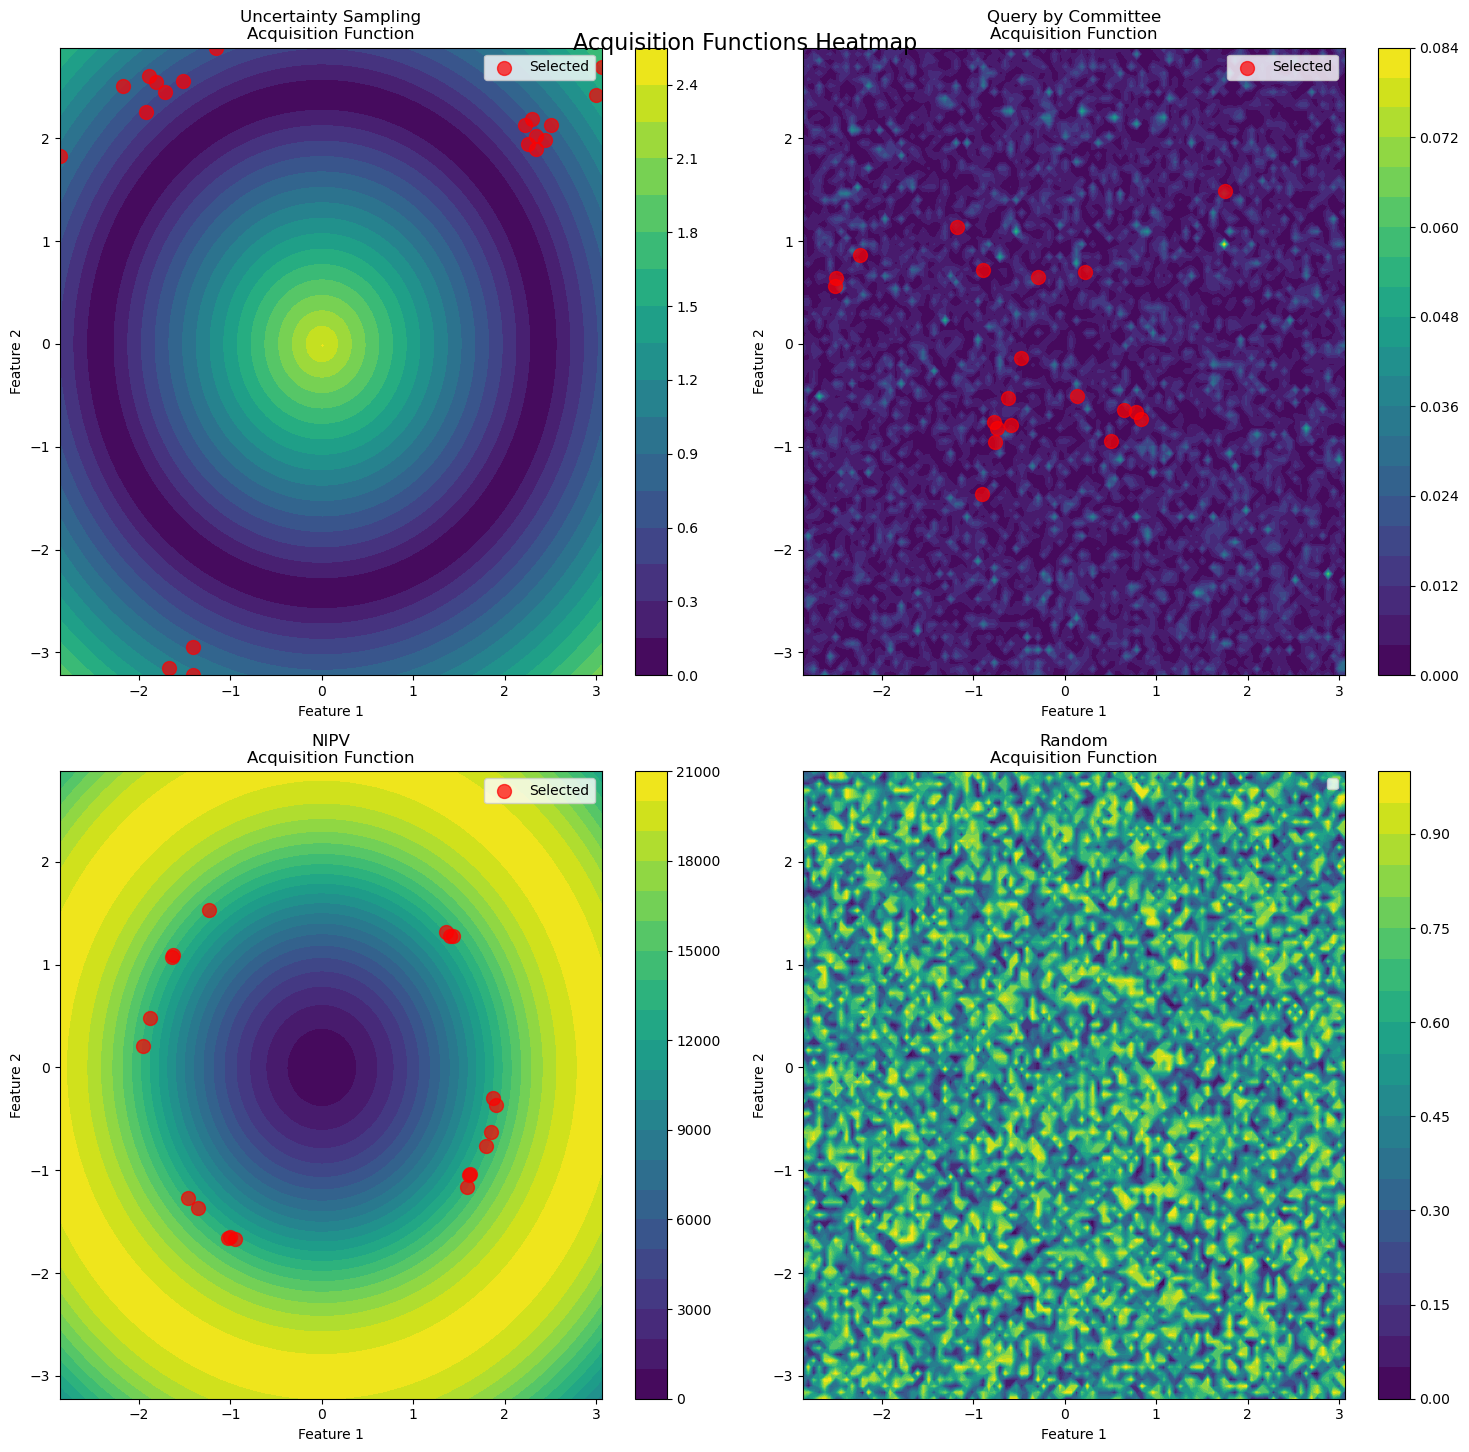

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import seaborn as sns

class ActiveLearningVisualizer:
    def __init__(self, n_samples=1000, n_features=2, n_informative=2, n_redundant=0):
        # Generate synthetic dataset
        self.X, self.y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=n_informative,
            n_redundant=n_redundant,
            random_state=42
        )
        
        # Standardize features
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)
        
        # Initialize selected indices for each strategy
        self.n_initial = 10
        self.n_queries = 20
        
    def simulate_uncertainty_sampling(self):
        """Simulate uncertainty sampling by selecting points near decision boundary"""
        # Calculate distance from origin as proxy for uncertainty
        distances = np.linalg.norm(self.X, axis=1)
        # Select points closest to decision boundary
        return np.argsort(np.abs(distances - np.median(distances)))[:self.n_queries]
    
    def simulate_qbc(self):
        """Simulate Query by Committee by selecting points with high variance"""
        # Use distance from multiple "committee members" as proxy for disagreement
        committee_votes = []
        for i in range(3):  # Simulate 3 committee members
            noise = np.random.normal(0, 0.1, self.X.shape)
            votes = np.linalg.norm(self.X + noise, axis=1)
            committee_votes.append(votes)
        
        # Calculate variance of votes
        disagreement = np.var(committee_votes, axis=0)
        return np.argsort(disagreement)[-self.n_queries:]
    
    def simulate_nipv(self):
        """Simulate NIPV by selecting points that maximize variance reduction"""
        # Use a combination of distance and density as proxy for variance reduction
        distances = np.linalg.norm(self.X, axis=1)
        density = np.sum(np.exp(-0.5 * np.square(distances.reshape(-1, 1) - distances)), axis=1)
        score = distances * density
        return np.argsort(score)[-self.n_queries:]
    
    def simulate_random(self):
        """Simulate random sampling"""
        return np.random.choice(len(self.X), self.n_queries, replace=False)
    
    def plot_strategies(self, save_path=None):
        """Plot all active learning strategies side by side"""
        strategies = {
            'Uncertainty Sampling': self.simulate_uncertainty_sampling(),
            'Query by Committee': self.simulate_qbc(),
            'NIPV': self.simulate_nipv(),
            'Random Sampling': self.simulate_random()
        }
        
        # Set up the plot
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        fig.suptitle('Comparison of Active Learning Strategies', fontsize=16, y=0.95)
        
        # Plot each strategy
        for (title, selected), ax in zip(strategies.items(), axes.ravel()):
            # Plot all points
            ax.scatter(self.X[:, 0], self.X[:, 1], c='lightgray', alpha=0.5, label='Unlabeled')
            
            # Plot selected points
            ax.scatter(self.X[selected, 0], self.X[selected, 1], 
                      c='red', s=100, alpha=0.7, label='Selected')
            
            # Add labels and title
            ax.set_title(title)
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
            ax.legend()
            
            # Add density contours
            sns.kdeplot(data=self.X, x=self.X[:, 0], y=self.X[:, 1], 
                       levels=5, alpha=0.3, ax=ax)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()
        
    def plot_acquisition_functions(self):
        """Plot the acquisition function values for each strategy"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        fig.suptitle('Acquisition Functions Heatmap', fontsize=16, y=0.95)
        
        # Create grid for contour plot
        x = np.linspace(self.X[:, 0].min(), self.X[:, 0].max(), 100)
        y = np.linspace(self.X[:, 1].min(), self.X[:, 1].max(), 100)
        X, Y = np.meshgrid(x, y)
        
        # Calculate acquisition values for each strategy
        grid_points = np.column_stack((X.ravel(), Y.ravel()))
        
        strategies = {
            'Uncertainty Sampling': lambda x: np.abs(np.linalg.norm(x, axis=1) - np.median(np.linalg.norm(x, axis=1))),
            'Query by Committee': lambda x: np.var([np.linalg.norm(x + np.random.normal(0, 0.1, x.shape), axis=1) for _ in range(3)], axis=0),
            'NIPV': lambda x: np.linalg.norm(x, axis=1) * np.sum(np.exp(-0.5 * np.square(np.linalg.norm(x, axis=1).reshape(-1, 1) - np.linalg.norm(x, axis=1))), axis=1),
            'Random': lambda x: np.random.rand(len(x))
        }
        
        for (title, func), ax in zip(strategies.items(), axes.ravel()):
            # Calculate acquisition values
            Z = func(grid_points).reshape(X.shape)
            
            # Create contour plot
            im = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
            plt.colorbar(im, ax=ax)
            
            # Plot selected points
            if title != 'Random':
                selected = np.argsort(func(self.X))[-self.n_queries:]
                ax.scatter(self.X[selected, 0], self.X[selected, 1], 
                          c='red', s=100, alpha=0.7, label='Selected')
            
            ax.set_title(f'{title}\nAcquisition Function')
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
            ax.legend()
        
        plt.tight_layout()
        plt.show()

# Usage example
visualizer = ActiveLearningVisualizer(n_samples=1000)

# Plot the strategies
visualizer.plot_strategies()

# Plot the acquisition functions
visualizer.plot_acquisition_functions()